# T-S diagrams and comparison

For reference: https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/TemperatureSalinityDiagrams.ipynb

In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
from dask import delayed
import numpy as np
import xarray as xr
from distributed.diagnostics.progressbar import progress
import cosima_cookbook as cc
import cmocean as cmo

import matplotlib.pyplot as plt
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from dask.distributed import Client
client = Client()
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33689/status,
Dashboard: /proxy/33689/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42891,Workers: 4
Dashboard: /proxy/33689/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:33753,Total threads: 4
Dashboard: /proxy/38833/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:33895,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice = slice(-80,-59)
lon_slice = slice(-280,80)
#isobath_depth = 1000

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC015/']
# cc.database.build_index(dir_list,basal_melt_session)

Get bathymetry. 

In [5]:
# get bathymetry
ht = cc.querying.getvar(control, 'ht', master_session, n=-1).sel(yt_ocean=lat_slice)

Define functions to read in data from control and simulation

In [6]:
def read_and_convert_TS(lat_slice, lon_slice, start_time, end_time):
    '''
    Reads T and S from control and Tfreeze_min simulation
    Restricts to shelf and region given by lat_slice and lon_slice
    Convert TS using gsw
    '''
    
    # control run
    temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    # temp_Tfreezing_min_calv_2 run
    temp_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    
    # temp_gade run
    temp_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'temp', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
    salt_Tfreezing_min_calv_2_gade = cc.querying.getvar(Tfreezing_min_calv_2_gade, 'salt', basal_melt_session, frequency='1 monthly',
                                          start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

    # subset temp and salinity only for shelf values
    temp = temp.where(ht<1000)
    salt = salt.where(ht<1000)
    temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.where(ht<1000)
    salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.where(ht<1000)
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.where(ht<1000)
    salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.where(ht<1000)
    
    # interpolate to evenly spaced 50 m vertical grid and load data
    z_even = np.arange(0,1050,50)
    salt = salt.interp(st_ocean = z_even).load()
    temp = temp.interp(st_ocean = z_even).load()
    salt_Tfreezing_min_calv_2 = salt_Tfreezing_min_calv_2.interp(st_ocean = z_even).load()
    temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2.interp(st_ocean = z_even).load()
    salt_Tfreezing_min_calv_2_gade = salt_Tfreezing_min_calv_2_gade.interp(st_ocean = z_even).load()
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade.interp(st_ocean = z_even).load()

    # subset for first region and load data
    #temp = temp.load()
    #salt = salt.load()
    #temp_Tf_min_s0 = temp_Tf_min_s0.load()
    #salt_Tf_min_s0 = salt_Tf_min_s0.load()
    print('Temp is' , temp.nbytes/1000**3, 'GB')
    
    # convert Temp to deg C
    temp = temp - 273.15
    temp_Tfreezing_min_calv_2 = temp_Tfreezing_min_calv_2 - 273.15
    temp_Tfreezing_min_calv_2_gade = temp_Tfreezing_min_calv_2_gade - 273.15
    # convert salinity to absolute salinity
    p = gsw.p_from_z(-salt.st_ocean,salt.yt_ocean)
    salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
    salt_Tfreezing_min_calv_2 = gsw.SA_from_SP(salt_Tfreezing_min_calv_2, p, salt_Tfreezing_min_calv_2.xt_ocean, salt_Tfreezing_min_calv_2.yt_ocean)
    salt_Tfreezing_min_calv_2_gade = gsw.SA_from_SP(salt_Tfreezing_min_calv_2_gade, p, salt_Tfreezing_min_calv_2_gade.xt_ocean, salt_Tfreezing_min_calv_2_gade.yt_ocean)
    
    return temp,salt,temp_Tfreezing_min_calv_2,salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade,salt_Tfreezing_min_calv_2_gade


Define figure functions

In [7]:
def figure(region):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(1,3, figsize=(18,7))
    sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.25, 27.5, 27.75, 28]
    for ax in axes.flatten():
        ax.set_ylim([-2,2])
        ax.set_xlim([32,35])
        ax.set_ylabel('Temperature (C)')
        ax.set_xlabel('Absolute Salinity')
        cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
        ax.clabel(cl, sig_lvls)
        
    return fig, axes, region

def create_colour_array(salt, salt_Tfreezing_min_calv_2):
    # create depth arrays for colouring scatter plot
    depth = salt.copy(deep=True)
    depth.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth[:,i,:,:] = depth.st_ocean[i]
    depth_Tfreeze = salt_Tfreezing_min_calv_2.copy(deep=True)
    depth_Tfreeze.rename('depth')
    for i in range(len(depth.st_ocean)):
        depth_Tfreeze[:,i,:,:] = depth_Tfreeze.st_ocean[i]

    # create latitude arrays for colouring scatter plot
    lat_arr = salt.copy(deep=True)
    lat_arr.rename('lat')
    for i in range(len(salt.yt_ocean)):
        lat_arr[:,:,i,:] = lat_arr.yt_ocean[i]
    lat_arr_Tfreeze = salt_Tfreezing_min_calv_2.copy(deep=True)
    lat_arr_Tfreeze.rename('lat')
    for i in range(len(salt_Tfreezing_min_calv_2.yt_ocean)):
        lat_arr_Tfreeze[:,:,i,:] = lat_arr_Tfreeze.yt_ocean[i]
        
    return depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze

# create density mesh for contours on T-S
temp_vals = np.arange(-2.5,1.5,.1)
salt_vals = np.arange(26,35.5,.01) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
density_for_contouring = gsw.density.rho(salt_mesh, temp_mesh, 1) #- 1000
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

Quickly plot regions of interest for reference.

--> Probably want to restrict these much closer to coastline.

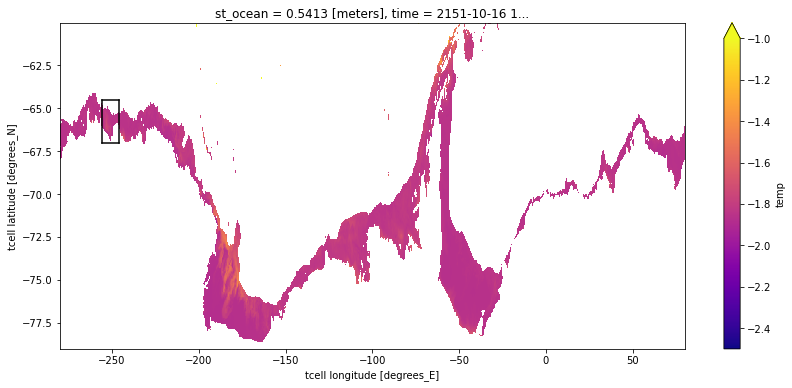

In [8]:
# first year only
start_time='2152-01-01'
end_time='2153-01-01'
lat_slice = slice(-79,-60)
lon_slice = slice(-280,80)
# read in T and S for region
temp = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',
                              start_time=start_time, end_time=end_time).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
temp = temp.where(ht<1000)

# plot regions of interest for quick reference check
(temp[0,0,:,:]-273.15).plot(figsize=(14,6), cmap='plasma', vmin=-2.5, vmax=-1)
#vincennes bay
plt.plot([-246,-246],[-67,-64.5],c='k')
plt.plot([-256,-256],[-67,-64.5],c='k')
plt.plot([-256,-246],[-67,-67],c='k')
plt.plot([-256,-246],[-64.5,-64.5],c='k')


plt.show()

In [9]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('YlGnBu')
new_cmap = truncate_colormap(cmap, 0.2, 1)

Now plot specific regions. 

### Vincennes Bay

#### Whole region

In [10]:
# first year only
start_time='2152-01-01'
end_time='2153-01-01'

# vincennes region
lat_slice = slice(-67,-64.5)
lon_slice = slice(-256,-246)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.014868 GB


# Gade line
Ribeiro et al. 2021 (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020JC016998) use gradient of 2.4 in Gade line

We can also create our own from Gade line equation

$$ \frac{d\Theta}{dS} = \frac{L}{S_0C_w} + \frac{(\Theta_f-T_i)C_i}{S_0C_w} + \frac{(\Theta_0-\Theta_f)}{S_0} $$

where:
- $L$ is latent heat of fusion, $3.35\times 10^5$J.kg$^{-1}$
- $\Theta_0$, $S_0$ are the **potential** temperature, and salinity of CDW source water
- $C_w$, $C_i$ are the specific heat capacities of water and ice - $4200$J.kg$^{-1}$.K$^{-1}$ and $2010$J.kg$^{-1}$.K$^{-1}$ respectively
- $\Theta_f$ is the potential freezing temperature at the ice base
- $T_i$ is the temperature of basal ice (Ribeiro et al. (2021) use -15$^\circ$C)

Thus the Gade line will be sensitive to
- depth (in freezing temperature)
- CDW conditions e.g. temperature, salinity

**Question**: Our model output is conservative, not potential temperature ....

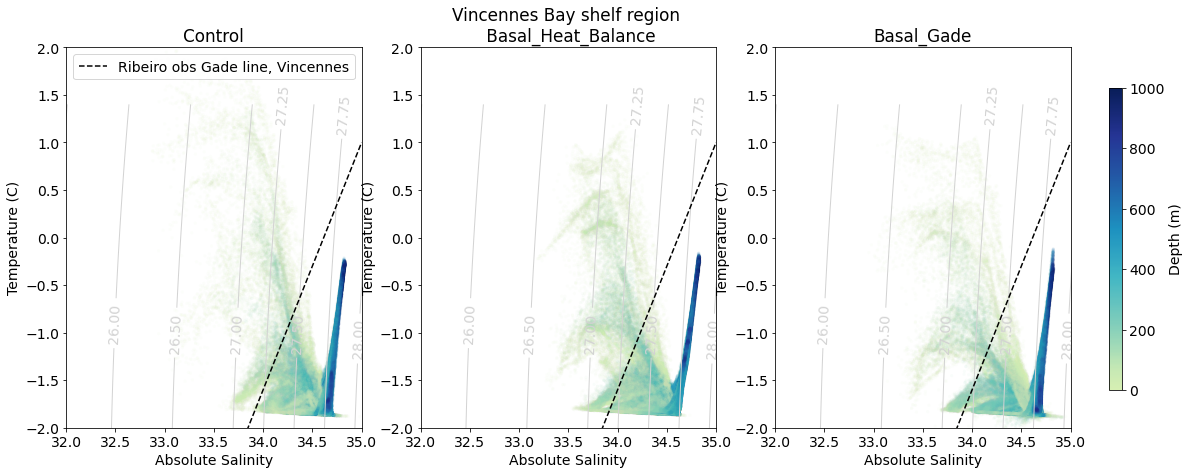

In [11]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Vincennes Bay')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[1].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[2].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
        
        # plot triangle
        #t_tmp = temp_Tfreezing_min_calv_2.where((temp_Tfreezing_min_calv_2 > -3.4*salt_Tfreezing_min_calv_2+115.9)  & 
        #                             (temp_Tfreezing_min_calv_2 > 8*salt_Tfreezing_min_calv_2-277.4) & 
        #                             (temp_Tfreezing_min_calv_2 > 4.5*salt_Tfreezing_min_calv_2-155.6))
        #s_tmp = salt_Tfreezing_min_calv_2.where(np.isfinite(t_tmp))
        #axes[1].scatter(s_tmp,t_tmp, c='r', alpha=0.8, s=1, zorder=3,edgecolors='none')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control')
    axes[1].set_title(f'{region} shelf region \n Basal_Heat_Balance')
    axes[2].set_title(f'Basal_Gade')
    
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    salts = np.linspace(32,35,10)
    for temp_intercept in [-90]:
        gade_line = 2.6*salts + temp_intercept
        axes[0].plot(salts,gade_line, linestyle = '--',color = 'k', label = 'Ribeiro obs Gade line, Vincennes')
        axes[1].plot(salts,gade_line, linestyle = '--',color = 'k')
        axes[2].plot(salts,gade_line, linestyle = '--',color = 'k')
    axes[0].legend()    
    plt.show()

#### plot different months

2022-11-23 12:14:02,559 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


1


2022-11-23 12:14:04,229 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Temp is 0.0059472 GB
2


2022-11-23 12:14:09,693 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
3


2022-11-23 12:14:13,371 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
4


2022-11-23 12:14:17,828 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Temp is 0.0059472 GB
5


2022-11-23 12:14:22,273 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
6


2022-11-23 12:14:26,831 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
7


2022-11-23 12:14:30,797 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Temp is 0.0059472 GB
8


2022-11-23 12:14:36,276 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
9


2022-11-23 12:14:40,056 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
10
Temp is 0.0059472 GB
11


2022-11-23 12:14:46,727 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-11-23 12:14:49,057 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Temp is 0.0029736 GB
12
Temp is 0.0029736 GB


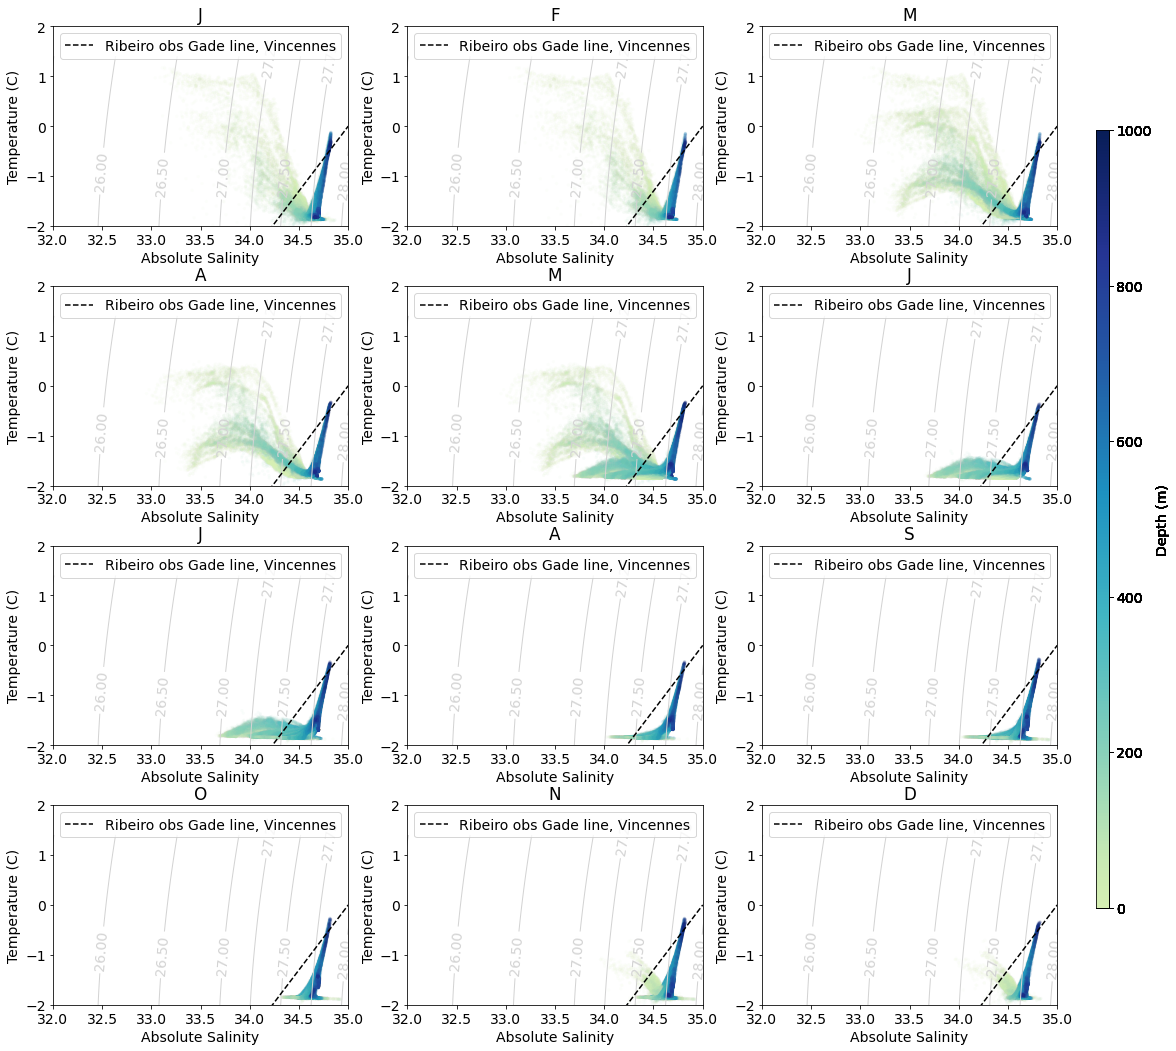

In [18]:
# vincennes region
lat_slice = slice(-67,-64.5)
lon_slice = slice(-256,-246)

plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(4,3, figsize=(18,18))
sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.25, 27.5, 27.75, 28]
for ax in axes.flatten():
    ax.set_ylim([-2,2])
    ax.set_xlim([32,35])
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('Absolute Salinity')
    cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
    ax.clabel(cl, sig_lvls)


for i in np.arange(1,13):
    print(i)
    start_time='2152-'+str(i).zfill(2)+'-01'
    end_time='2152-'+str(i).zfill(2)+'-31'

    # read in T and S for region
    temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

    # create arrays for scatter colouring
    depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)
    # plot figure
    scatter_colour = ['depth']#,'lat']
    s, alph, cmap = 10, 0.05, new_cmap
    ax = axes.flatten()[i-1]
    ax.scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
    c = ax.scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
    plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    ax.set_title(['J','F','M','A','M','J','J','A','S','O','N','D'][i-1])
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    salts = np.linspace(32,35,10)
    for temp_intercept in [-91]:
        gade_line = 2.6*salts + temp_intercept
        ax.plot(salts,gade_line, linestyle = '--',color = 'k', label = 'Ribeiro obs Gade line, Vincennes')
    ax.legend()    
fig.subplots_adjust(hspace = 0.3)
plt.show()

2022-11-23 12:22:24,741 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


1


2022-11-23 12:22:27,231 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0006048 GB
2


2022-11-23 12:22:32,307 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0003024 GB
3


2022-11-23 12:22:36,240 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0003024 GB
4


2022-11-23 12:22:41,907 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0006048 GB
5


2022-11-23 12:22:45,723 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0003024 GB
6
Temp is 0.0003024 GB
7


2022-11-23 12:22:52,598 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-11-23 12:22:54,198 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0006048 GB
8
Temp is 0.0003024 GB
9


2022-11-23 12:23:01,180 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Temp is 0.0003024 GB
10


2022-11-23 12:23:05,504 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Temp is 0.0006048 GB
11


2022-11-23 12:23:09,547 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-11-23 12:23:11,825 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Temp is 0.0003024 GB
12
Temp is 0.0003024 GB


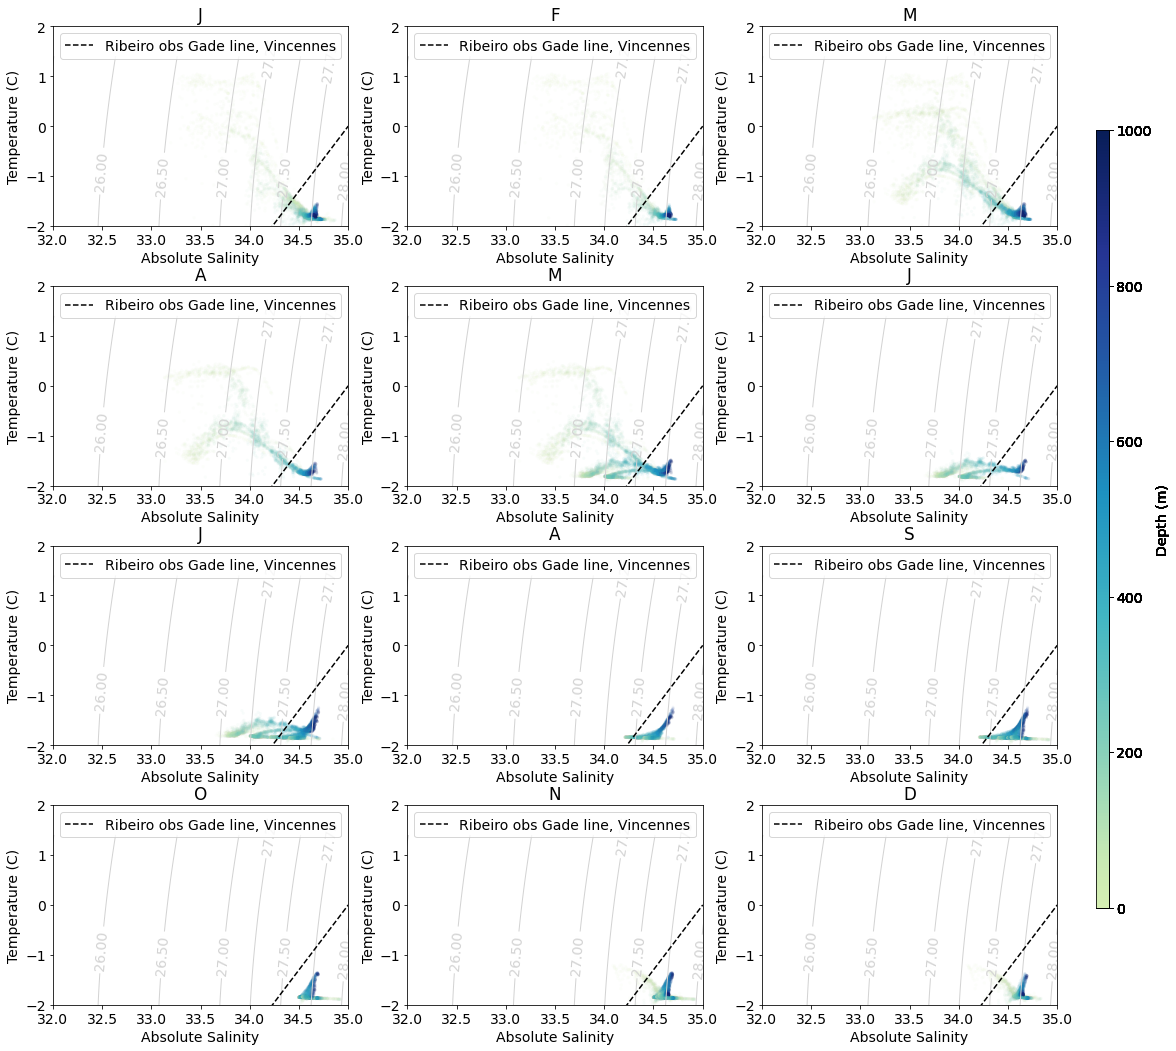

In [19]:
# vincennes polynya region
lat_slice = slice(-66.8,-65.8)
lon_slice = slice(-250.5,-248)

plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(4,3, figsize=(18,18))
sig_lvls = [24, 24.5, 25, 25.5, 26, 26.5, 27, 27.25, 27.5, 27.75, 28]
for ax in axes.flatten():
    ax.set_ylim([-2,2])
    ax.set_xlim([32,35])
    ax.set_ylabel('Temperature (C)')
    ax.set_xlabel('Absolute Salinity')
    cl = ax.contour(salt_mesh,temp_mesh,sigma0_for_contouring, sig_lvls,colors='lightgrey',linewidths=1)
    ax.clabel(cl, sig_lvls)


for i in np.arange(1,13):
    print(i)
    start_time='2152-'+str(i).zfill(2)+'-01'
    end_time='2152-'+str(i).zfill(2)+'-31'

    # read in T and S for region
    temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

    # create arrays for scatter colouring
    depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)
    # plot figure
    scatter_colour = ['depth']#,'lat']
    s, alph, cmap = 10, 0.05, new_cmap
    ax = axes.flatten()[i-1]
    ax.scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
    c = ax.scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
    plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
    ax.set_title(['J','F','M','A','M','J','J','A','S','O','N','D'][i-1])
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    salts = np.linspace(32,35,10)
    for temp_intercept in [-91]:
        gade_line = 2.6*salts + temp_intercept
        ax.plot(salts,gade_line, linestyle = '--',color = 'k', label = 'Ribeiro obs Gade line, Vincennes')
    ax.legend()    
fig.subplots_adjust(hspace = 0.3)
plt.show()

## Amery

In [12]:
# first year only
start_time='2152-01-01'
end_time='2153-01-01'

# Amundsen Sea region
lat_slice = slice(-73.5,-68)
lon_slice = slice(66,76)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

Temp is 0.03276 GB


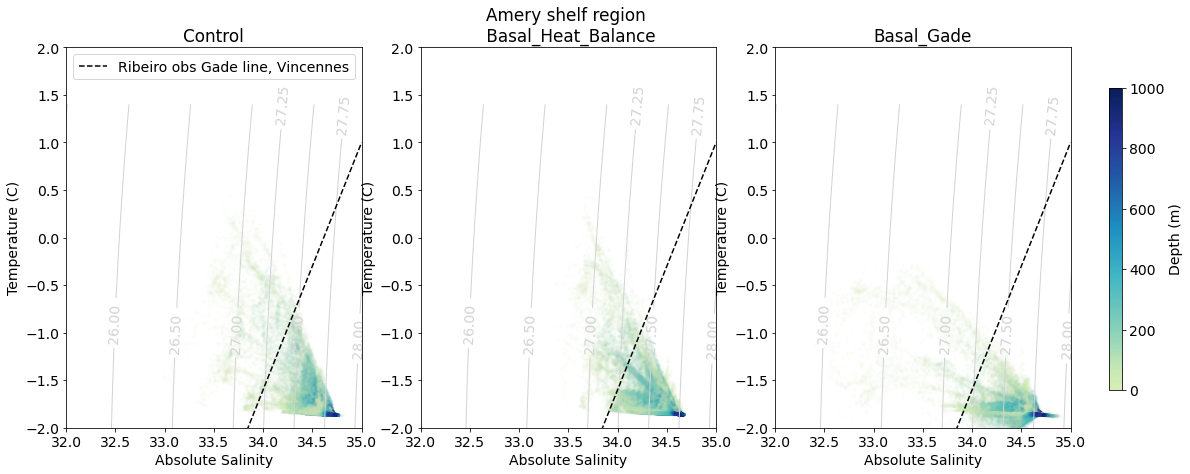

In [13]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Amery')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[1].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[2].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
        
        # plot triangle
        #t_tmp = temp_Tfreezing_min_calv_2.where((temp_Tfreezing_min_calv_2 > -3.4*salt_Tfreezing_min_calv_2+115.9)  & 
        #                             (temp_Tfreezing_min_calv_2 > 8*salt_Tfreezing_min_calv_2-277.4) & 
        #                             (temp_Tfreezing_min_calv_2 > 4.5*salt_Tfreezing_min_calv_2-155.6))
        #s_tmp = salt_Tfreezing_min_calv_2.where(np.isfinite(t_tmp))
        #axes[1].scatter(s_tmp,t_tmp, c='r', alpha=0.8, s=1, zorder=3,edgecolors='none')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control')
    axes[1].set_title(f'{region} shelf region \n Basal_Heat_Balance')
    axes[2].set_title(f'Basal_Gade')
    
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    salts = np.linspace(32,35,10)
    for temp_intercept in [-90]:
        gade_line = 2.6*salts + temp_intercept
        axes[0].plot(salts,gade_line, linestyle = '--',color = 'k', label = 'Ribeiro obs Gade line, Vincennes')
        axes[1].plot(salts,gade_line, linestyle = '--',color = 'k')
        axes[2].plot(salts,gade_line, linestyle = '--',color = 'k')
    axes[0].legend()    
    plt.show()

## Amundsen

In [ ]:
# first year only
start_time='2152-01-01'
end_time='2153-01-01'

# Amundsen Sea region
lat_slice = slice(-76,-70)
lon_slice = slice(-150,-100)
# read in T and S for region
temp, salt, temp_Tfreezing_min_calv_2, salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2_gade, salt_Tfreezing_min_calv_2_gade = read_and_convert_TS(lat_slice,lon_slice, start_time,end_time)

# create arrays for scatter colouring
depth, depth_Tfreeze, lat_arr, lat_arr_Tfreeze = create_colour_array(salt, salt_Tfreezing_min_calv_2)
depth_g, depth_Tfreeze_g, lat_arr_g, lat_arr_Tfreeze_g = create_colour_array(salt, salt_Tfreezing_min_calv_2_gade)

In [ ]:
# plot figure
scatter_colour = ['depth']#,'lat']
s, alph, cmap = 10, 0.05, new_cmap

sa = np.arange(32,35,0.01)
t_func_l = -3.4*sa+115.9
t_func_r1 = 4.5*sa-155.6#155.8
t_func_r2 = 8*sa-277.3#.43

for f in range(1):
    fig, axes, region = figure('Amundsen Sea')
    
    if scatter_colour[f] == 'depth':
        axes[0].scatter(salt,temp, c=depth, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[1].scatter(20,0, s=s, c=5, vmin=0, vmax=1000, cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[2].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        #axes[1].scatter(salt_Tfreezing_min_calv_2_gade,temp_Tfreezing_min_calv_2_gade, c=depth_Tfreeze_g - depth_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Depth (m)')
        
        # plot triangle
        #t_tmp = temp_Tfreezing_min_calv_2.where((temp_Tfreezing_min_calv_2 > -3.4*salt_Tfreezing_min_calv_2+115.9)  & 
        #                             (temp_Tfreezing_min_calv_2 > 8*salt_Tfreezing_min_calv_2-277.4) & 
        #                             (temp_Tfreezing_min_calv_2 > 4.5*salt_Tfreezing_min_calv_2-155.6))
        #s_tmp = salt_Tfreezing_min_calv_2.where(np.isfinite(t_tmp))
        #axes[1].scatter(s_tmp,t_tmp, c='r', alpha=0.8, s=1, zorder=3,edgecolors='none')
    else:
        axes[0].scatter(salt,temp, c=lat_arr, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        c = axes[0].scatter(20,0, s=s, c=-70, vmin=lat_arr.min(), vmax=lat_arr.max(), cmap=cmap, alpha=1) # plot dummy point for colorbar sake
        axes[1].scatter(salt_Tfreezing_min_calv_2,temp_Tfreezing_min_calv_2, c=lat_arr_Tfreeze, cmap=cmap, alpha=alph, s=s, edgecolors='none')
        plt.colorbar(c, cax = fig.add_axes([0.93, 0.2, 0.01, 0.6]), orientation = 'vertical').set_label('Latitude')

    axes[0].set_title(f'Control')
    axes[1].set_title(f'{region} shelf region \n Basal_Heat_Balance')
    axes[2].set_title(f'Basal_Gade')
    
    #axes[0].plot(sa,t_func_l,c='orange',lw=2)
    #axes[0].plot(sa,t_func_r1,c='orangered',lw=2)
    #axes[0].plot(sa,t_func_r2,c='green',lw=2)
    salts = np.linspace(32,35,10)
    for temp_intercept in [-90,-88,-86]:
        gade_line = 2.6*salts + temp_intercept
        axes[0].plot(salts,gade_line, linestyle = '--',color = 'k')
        axes[1].plot(salts,gade_line, linestyle = '--',color = 'k')
        axes[2].plot(salts,gade_line, linestyle = '--',color = 'k')
        
    plt.show()